# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 


In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import glob
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

import xgboost as xgb

import os

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/root/train.csv'
test_path  = '/root/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [3]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [4]:
df_bus = pd.read_csv("/root/bus_feature.csv")
df_metro = pd.read_csv("/root/subway_feature.csv")

In [9]:
df_interest_rate = pd.read_csv("./extra_data/base_rate.csv")

### EDA

In [10]:
dt['구'] = dt['시군구'].map(lambda x : x.split()[1])
dt['동'] = dt['시군구'].map(lambda x : x.split()[2])
del dt['시군구']

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
del dt_test['시군구']

In [11]:
mean_val_by_gu = dt.groupby("구")["target"].mean().sort_values(ascending=False)
mean_val_by_dong = dt.groupby("동")["target"].mean().sort_values(ascending=False)
std_val_by_gu = dt.groupby("구")["target"].std().sort_values(ascending=False)
std_val_by_dong = dt.groupby("동")["target"].std().sort_values(ascending=False)

### Data Preprocessing

#### concat

In [12]:
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])

In [13]:
df['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [14]:
del dt, dt_test

#### preprocess

In [15]:
df['계약년'] = df['계약년월'].map(lambda x : x // 100)
df['계약월'] = df['계약년월'].map(lambda x : x % 100)

df["date"] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [16]:
df['is_public'] = df["k-전용면적별세대현황(60㎡이하)"].notnull()

In [17]:
drop_cols_k = ['k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob',
                'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 
                'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 
                'k-사용검사일-사용승인일', 'k-연면적', 'k-관리비부과면적', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']

df.drop(columns=drop_cols_k, inplace=True)
df.drop(columns = ['번지', '본번', '부번'], inplace=True)

In [18]:
df.rename(columns={'도로명': 'street'}, inplace=True)

In [19]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

In [20]:
# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

df['구_encoded'] = df["구"].map(gu_mapping1)
df['구_std'] = df["구"].map(gu_mapping2)
df['동_encoded'] = df["동"].map(dong_mapping1)
df['동_std'] = df["동"].map(dong_mapping2)

In [21]:
seoul_bds = ["강남구", "영등포구", "용산구"]

df["has_bds"] = df["구"].apply(lambda x : 1 if x in seoul_bds else 0)

In [22]:
df['yrs_diff_built_contract'] = df['계약년'] - df['건축년도']
df['built_in3yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x <= 3 else 0)
df['built_in5yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x <= 5 else 0)
df['built_over30yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 30 else 0)
df['built_over35yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 35 else 0)
df['built_over40yrs'] = df['yrs_diff_built_contract'].apply(lambda x : 1 if x >= 40 else 0)

In [23]:
df['road'] = df['street'].apply(lambda x : x.split()[0] if len(x.split()) > 0 else x)
df['on_main_st'] = df['road'].apply(lambda x: not any(char.isdigit() for char in x))
del df['road']

In [24]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
df['등기신청일자'] = df['등기신청일자'].replace(' ', np.nan)
df['거래유형'] = df['거래유형'].replace('-', np.nan)
df['중개사소재지'] = df['중개사소재지'].replace('-', np.nan)

### extra data

#### 구별 특성

##### 시군구 단위 용도지역 현황 (2022)

In [25]:
df_zones_original = pd.read_csv("./extra_data/2022_zoning_seoul.csv", encoding='euc-kr')

In [26]:
df_zones_original['주거지역_전용주거_비율'] = df_zones_original['주거지역_전용주거_소계'] / df_zones_original['도시지역 면적']
df_zones_original['주거지역_일반주거_비율'] = df_zones_original['주거지역_일반주거지역_소계'] / df_zones_original['도시지역 면적']
df_zones_original['주거지역_준주거_비율'] = df_zones_original['주거지역_준주거지역'] / df_zones_original['도시지역 면적']
df_zones_original['중심상업_비율'] = df_zones_original['상업지역_중심상업'] / df_zones_original['도시지역 면적']
df_zones_original['일반상업_비율'] = df_zones_original['상업지역_일반상업'] / df_zones_original['도시지역 면적']
df_zones_original['근린상업_비율'] = df_zones_original['상업지역_근린상업'] / df_zones_original['도시지역 면적']

In [27]:
df_zone_ratio = df_zones_original[['시군구', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율',
       '중심상업_비율', '일반상업_비율', '근린상업_비율']]

In [28]:
df_zone_ratio.rename(columns={'시군구': '구'}, inplace=True)

In [29]:
df = pd.merge(left=df, right=df_zone_ratio, on='구', how='left')

##### 2022_학생_1만명당_사설학원수

In [30]:
df_academies = pd.read_csv("extra_data/2022_학생_1만명당_사설학원수_20240326124719.csv", encoding='euc-kr')

In [31]:
df_academies.rename(columns={"자치구":"구"}, inplace=True)
df_academies.drop(columns=['초중고_학생수(명)', '사설학원수(개소)'], inplace=True)

In [32]:
df = pd.merge(left=df, right=df_academies, on='구', how='left')

#### 경제지표

##### 기준금리

In [33]:
df_interest_rate.rename(columns={'날짜': 'date'}, inplace=True)
df_interest_rate['date'] = pd.to_datetime(df_interest_rate['date'])

In [34]:
df = pd.merge(df, df_interest_rate, on = 'date', how='left')

##### KOSPI

In [35]:
# Use glob to find all files that match the pattern
file_paths = glob.glob("./extra_data/KOSPI_*.csv")

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

In [36]:
kospi_df = pd.concat(dfs, ignore_index=True)

kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [37]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [38]:
kospi_df["KOSPI_MA5d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=5).mean())
kospi_df["KOSPI_MA20d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=20).mean())
kospi_df["KOSPI_MA60d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=60).mean())
kospi_df["KOSPI_MA120d"] = kospi_df["Close"].transform(lambda x: x.rolling(window=120).mean())

In [39]:
kospi_cols = ['Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액',
       'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d', 'KOSPI_MA120d']

In [40]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [41]:
df[kospi_cols] = df[kospi_cols].interpolate(method='linear', axis=0)

##### 실업률

In [42]:
unempl_rate = pd.read_csv("./extra_data/서울시_월별실업률_2007_2024.csv", encoding="euc-kr")

In [43]:
unempl_rate["시점"] = unempl_rate["시점"]*100
unempl_rate["시점"] = unempl_rate["시점"].astype(int)
unempl_rate.rename(columns={"계" : "unempl_rate_total", "남자": "unempl_male", "여자":"unempl_female"}, inplace=True)

In [44]:
df = pd.merge(left=df, right=unempl_rate, left_on="계약년월", right_on="시점", how="left")
df.drop(columns=['시점'], inplace=True)

### delete columns

In [316]:
df.columns

Index(['아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', 'street', '해제사유발생일',
       '등기신청일자', '거래유형', '중개사소재지', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동',
       'is_test', '계약년', '계약월', 'date', 'is_public', '구_encoded', '구_std',
       '동_encoded', '동_std', 'has_bds', 'yrs_diff_built_contract',
       'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs',
       'built_over40yrs', 'on_main_st', '주거지역_비율', '상업지역_비율', '공업지역_비율',
       '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율',
       '일반상업_비율', '근린상업_비율', '학생1만명당_사설학원수(개소)', '기준금리', 'Close', '대비', '등락률',
       '거래량', '거래대금', '상장시가총액', 'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d',
       'KOSPI_MA120d', 'unempl_rate_total', 'unempl_male', 'unempl_female'],
      dtype='object')

In [45]:
drop_cols_before_train = ['date', '좌표X', '좌표Y', '구', '동', '계약월', '계약일', '고용보험관리번호', 'k-수정일자', '관리비 업로드', '기타/의무/임대/임의=1/2/3/4', '계약년']

df.drop(columns=drop_cols_before_train, inplace=True)

df.columns = df.columns.str.replace('[^\w\s]', '')
df.columns = df.columns.str.replace(' ', '_')

In [46]:
df.columns

Index(['아파트명', '전용면적', '계약년월', '층', '건축년도', 'street', '해제사유발생일', '등기신청일자',
       '거래유형', '중개사소재지', 'k주거전용면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하',
       'k85135이하', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '단지승인일',
       '사용허가여부', '단지신청일', 'target', 'is_test', 'is_public', '구_encoded',
       '구_std', '동_encoded', '동_std', 'has_bds', 'yrs_diff_built_contract',
       'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs',
       'built_over40yrs', 'on_main_st', '주거지역_비율', '상업지역_비율', '공업지역_비율',
       '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율',
       '일반상업_비율', '근린상업_비율', '학생1만명당_사설학원수개소', '기준금리', 'Close', '대비', '등락률',
       '거래량', '거래대금', '상장시가총액', 'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d',
       'KOSPI_MA120d', 'unempl_rate_total', 'unempl_male', 'unempl_female'],
      dtype='object')

In [47]:
df['k전용면적별세대현황60이하'] = df['k전용면적별세대현황60이하'].fillna(0)

In [48]:
df['k전용면적별세대현황6085이하'] = df['k전용면적별세대현황6085이하'].fillna(0)
df['k85135이하'] = df['k85135이하'].fillna(0)

In [50]:
# 해제사유발생일, 등기신청일자, 거래유형, 중개사소재지 - 삭제해도 될 듯
df.drop(columns=['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지'], inplace=True)

In [49]:
def info_df(df):
    temp_df = pd.DataFrame()
    temp_df['col_name'] = df.columns
    

    for i in range(len(df.columns)):
        x = df.iloc[:, i]
        temp_df.loc[i, 'data_type'] = x.dtype
        temp_df.loc[i, 'have_null'] = any(x.isna())
        temp_df.loc[i, 'null_count'] = x.isna().sum()
        temp_df.loc[i, 'null_ratio'] = x.isna().sum() / x.shape[0]
        temp_df.loc[i, 'nunique'] = x.nunique()
    return temp_df

In [51]:
# Set the display option to show all rows
pd.set_option('display.max_rows', None)
info_df(df)

,col_name,data_type,have_null,null_count,null_ratio,nunique
0,아파트명,object,True,2136.0,0.001893,6549.0
1,전용면적,float64,False,0.0,0.000000,14670.0
2,계약년월,int64,False,0.0,0.000000,201.0
3,층,int64,False,0.0,0.000000,73.0
4,건축년도,int64,False,0.0,0.000000,60.0
5,street,object,False,0.0,0.000000,9245.0
6,k주거전용면적,float64,True,876170.0,0.776682,740.0
7,k전용면적별세대현황60이하,float64,False,0.0,0.000000,349.0
8,k전용면적별세대현황6085이하,float64,False,0.0,0.000000,387.0
9,k85135이하,float64,False,0.0,0.000000,244.0


In [ ]:
# k주거전용면적 - 전용면적과 비교후 삭제해도 되는지 판단

In [54]:
pd.reset_option('display.max_rows')

## 5. Model Training

In [218]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = df.query('is_test==0')
dt_test = df.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 73) (9272, 73)


In [219]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

############ 인코딩에서 막힘

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [220]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '해제사유발생일', 'k주거전용면적', 'k전용면적별세대현황60이하', 'k전용면적별세대현황6085이하', 'k85135이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '계약년', '계약월', 'is_public', '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds', 'yrs_diff_built_contract', 'built_in3yrs', 'built_in5yrs', 'built_over30yrs', 'built_over35yrs', 'built_over40yrs', 'on_main_st', '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', '주거지역_전용주거_비율', '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율', '일반상업_비율', '근린상업_비율', '학생1만명당_사설학원수개소', '기준금리', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액', 'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d', 'KOSPI_MA120d', 'unempl_rate_total', 'unempl_male', 'unempl_female']
범주형 변수: ['아파트명', 'street', '등기신청일자', '거래유형', '중개사소재지', 'k수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타의무임대임의1234', '단지승인일', '사용허가여부', '관리비_업로드', '단지신청일', '구', '동', 'date']


In [ ]:
# 범주형 변수에 대한 보간
df[categorical_columns_v2] = df[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
df[continuous_columns_v2] = df[continuous_columns_v2].interpolate(method='linear', axis=0)

In [ ]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(df[col].astype(str))
    df[col] = lbl.transform(df[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df[col] = lbl.transform(df[col].astype(str))

### 5.2. Model Training

In [199]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [201]:
drop_cols_before_train = 

In [202]:
dt_train = dt_train.drop(columns=drop_cols_before_train)
dt_test = dt_test.drop(columns=drop_cols_before_train)

In [203]:
dt_train.columns

Index(['전용면적', '계약년월', '층', '건축년도', 'k주거전용면적', 'k전용면적별세대현황60이하',
       'k전용면적별세대현황6085이하', 'k85135이하', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '단지승인일', '사용허가여부', '단지신청일', 'target', 'is_public',
       '기준금리', '구_encoded', '구_std', '동_encoded', '동_std', 'has_bds',
       '주거지역_비율', '상업지역_비율', '공업지역_비율', '녹지지역_비율', '주거지역_전용주거_비율',
       '주거지역_일반주거_비율', '주거지역_준주거_비율', '중심상업_비율', '일반상업_비율', '근린상업_비율',
       '학생1만명당_사설학원수개소', 'yrs_diff_built_contract', 'built_in3yrs',
       'built_in5yrs', 'built_over30yrs', 'built_over35yrs', 'built_over40yrs',
       'on_main_st', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액',
       'KOSPI_MA5d', 'KOSPI_MA20d', 'KOSPI_MA60d', 'KOSPI_MA120d',
       'unempl_rate_total', 'unempl_male', 'unempl_female'],
      dtype='object')

In [204]:
print(dt_train.shape, dt_test.shape)

(1118822, 55) (9272, 55)


In [205]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

In [206]:
# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [207]:
X_test = dt_test.drop(['target'], axis=1)

In [208]:
# Define parameters for XGBRegressor
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression task
    'eval_metric': 'rmse',  # Root Mean Squared Error for evaluation
    'max_depth': 12,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bynode': 0.8,
    'reg_lambda': 1,
    'random_state': 42,
}

# Create and train the XGBRegressor model
model_xgb1 = xgb.XGBRegressor(**params)
model_xgb1.fit(X_train, y_train)

# Make predictions on the validation set
pred_xgb1 = model_xgb1.predict(X_val)

In [209]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE val: {np.sqrt(metrics.mean_squared_error(y_val, pred_xgb1))}')

RMSE val: 6998.347686702911


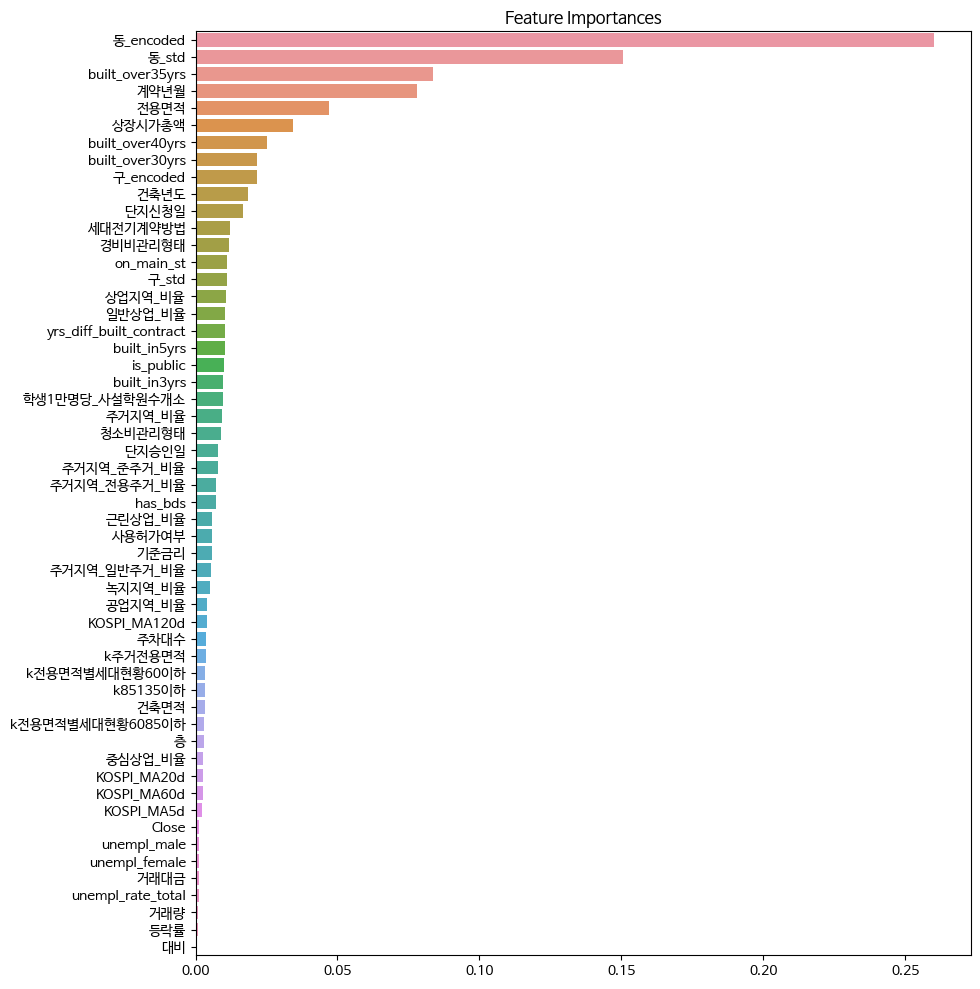

In [210]:
importances = pd.Series(model_xgb1.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 12))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [643]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('model_xgb1.pkl', 'wb') as f:
    pickle.dump(model_xgb1, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [312]:
# # Permutation importance 방법을 변수 선택에 이용해보겠습니다.
# perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
#                              scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
#                              random_state = 42,
#                              n_iter=3).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1115100604.8982 ± 16011314.4157,전용면적
1012592379.8384 ± 9979412.9561,동_encoded
998076962.4988 ± 7148859.3022,계약년월
408483981.9837 ± 1699485.3199,동_std
179847539.9027 ± 4178794.3527,건축년도
39009181.6323 ± 733301.9405,부번
27655840.5256 ± 658130.5952,도로명
23801508.9218 ± 1016627.3693,동
21363376.5972 ± 192892.0522,yrs_diff_built_contract
20618314.2286 ± 243254.3049,구_encoded


## 6. Inference

In [644]:
# 저장된 모델을 불러옵니다.
with open('model_xgb1.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [645]:
%%time
X_test.columns = X_test.columns.str.replace('[^\w\s]', '')
X_test.columns = X_test.columns.str.replace(' ', '_')

CPU times: user 655 µs, sys: 0 ns, total: 655 µs
Wall time: 664 µs


In [646]:
# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model1.predict(X_test)

## 7. Output File Save

In [647]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)